In [1]:
# Data downloaded from https://www.kaggle.com/uciml/pima-indians-diabetes-database#diabetes.csv: 
import pandas as pd
d = pd.read_csv("/home/chidung/Desktop/python_learning/pima/diabetes.csv")

In [2]:
#==========================
# Perform data-processing
#==========================

# Drop Pregnancies and Outcome column: 
d1 = d.drop(["Pregnancies", "Outcome"], axis = 1)

# Convert zeros to NA values: 
import numpy as np
d1 = d1.replace(0, np.nan)

# Replace NA values by mean: 
d1 = d1.fillna(d1.mean())

# Add Pregnancies column: 
df = d1.assign(Pregnancies = d["Pregnancies"])

# Write a function for normalizing 0 - 1 data: 
def normalize_01(data):
    nho_nhat = data.min()
    lon_nhat = data.max(0)
    scaled = (data - nho_nhat) / (lon_nhat - nho_nhat)
    return scaled

# Apply this function for our data: 
df = df[["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", 
        "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"]].apply(normalize_01)

# Add Outcome column: 
df = df.assign(Outcome = d["Outcome"])

In [3]:
# Write a function for spliting data: 

my_seed = 29
np.random.seed(my_seed)

from sklearn.model_selection import train_test_split

def split_my_data(test_size):
    
    Y = df["Outcome"] # Target variable. 
    X = df.drop("Outcome", 1) # Predictors. 
    
    # Split Data into train and test sets: 
    xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = test_size, random_state = my_seed)  
    return (xtrain, xtest, ytrain, ytest)

In [4]:
# Use above function: 
xtrain, xtest, ytrain, ytest = split_my_data(test_size = 0.3)

In [5]:
# Load some ML Models: 

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline

In [6]:
#==========================
#   Train some ML Moldes
#==========================


# Write a function for training some ML Models selected: 

def get_models():
    # Some ML Models selected: 
    nb = GaussianNB()
    svc = SVC(C = 100, probability = True)
    knn = KNeighborsClassifier(n_neighbors = 7)
    lr = LogisticRegression(C = 100)
    nn = MLPClassifier((80, 10), early_stopping = False, random_state = my_seed)
    gb = GradientBoostingClassifier(n_estimators = 100, random_state = my_seed)
    rf = RandomForestClassifier(n_estimators = 10, max_features = 3, random_state = my_seed)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models

In [7]:
# A function for training ML models and return predictions: 

def train_predict(model_list):
    
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    cols = list()
    for i, (name, m) in enumerate(models.items()):
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)

    P.columns = cols
    return P

In [8]:
# Function calculates AUC for ML Models: 

from sklearn.metrics import roc_auc_score

def score_models(P, y):
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))

In [9]:
models = get_models()
P = train_predict(models)
results = score_models(P, ytest)
results

svm                       : 0.851
knn                       : 0.796
naive bayes               : 0.839
mlp-nn                    : 0.842
random forest             : 0.787
gbm                       : 0.810
logistic                  : 0.841


In [10]:
# Ensemble ROC-AUC: 
roc_auc_score(ytest, P.mean(axis=1))

0.8458831232607628

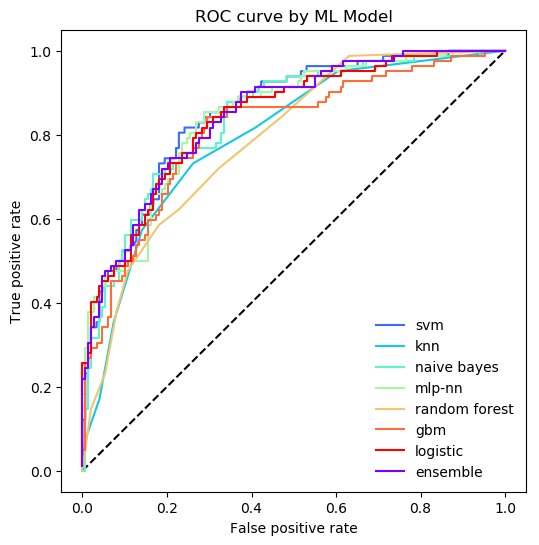

In [11]:
# Function for plots ROC curves: 

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("default")

from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    
    plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    
    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]
    
    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])
        
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve by ML Model')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")